In [34]:
#In this notebook, we're going to look at how to add convolutions into our network.
#We'll be using this to run a convolutional network, and contrasting the convolutional
#approach to the non-convolutonal approach we've used to date.

import pickle
import numpy as np
import collections
import copy
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline


with open("testTrainLab2.pickle", "rb") as f:
    labData = pickle.load(f)

y_train = labData["y_train"]
y_test = labData["y_test"]

def preProcessing(train, test, arrayReshape=True, zeroShift=True, zeroShiftVis = True):
    if(zeroShift == True):
        mean_image = np.average(train, axis=0)
        if(zeroShiftVis == True):
            plt.figure(figsize=(4,4))
            plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
            plt.show()
        train -= mean_image
        test -= mean_image

    if(arrayReshape == True):
        train = np.reshape(train, (train.shape[0], -1))
        test = np.reshape(test, (test.shape[0], -1))

    return(train, test)

#Note that we're setting arrayReshape to false for convolutional
#approaches, as we need to retain the image structure.
X_train, X_test = preProcessing(train = labData["X_train"].copy(), 
                                test = labData["X_test"].copy(),
                                arrayReshape = False,
                                zeroShift = True,
                                zeroShiftVis = False)


#Of note, now our X_train dimensions are 50,000 x 32 x 32 x 3 -
#this represents the 50k examples that are each 32x32x3(color bands) images
#in CIFAR.  IN previous steps, we've flattened these out into a 
#50,000 x 3072 matrix, but we won't be doing that 
#if we want to convolve.
print(X_train.shape)

#We're also going to split our training dataset one more time here, so that we have
#an independent validation and testing dataset.  Go all the way back to lecture 2
#for more on this approach!
s1 = np.random.choice(range(X_train.shape[0]), 10000, replace=False)
s2 = list(set(range(X_train.shape[0])) - set(s1))

y_val = y_train[s1]
y_train = y_train[s2]
X_val = X_train[s1, :, :]
X_train = X_train[s2, :, :]

(50000, 32, 32, 3)


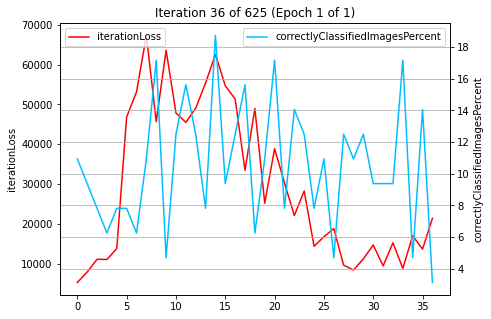

KeyboardInterrupt: 

In [28]:
#We're going to use a class this time, but we'll be implementing it in a modular fashion.
#Your challenge will be to build on this example to do things like
#add more layers for the lab assignment.
#We're also going to implement a more rigorous training procedure
#with epochs for the first time!  The class below builds heavily on
#the class we wrote in part 3.

#The example version of this class is going to implement a two-layer ConvNet,
#But you're going to want to go further for the lab submission.

#Note this is going to be quite computationally expensive!  

modelArchitecture = [{'layerType':'convolutional', 'inputSize':3072, 'outputSize':20, 'filterSize':5},
                     {'layerType':'relu', 'inputSize':20, 'outputSize':20},
                     {'layerType':'affine', 'inputSize':20, 'outputSize':10, 'activation':"relu"}]
    

class convolutionalNeuralNet():
    def __init__(self, modelArchitecture,
                X_train, y_train, X_test, y_test, X_val, y_val,
                weightType = "He"):
        self.weights = {}
        self.gradients = {}
        self.weightType = weightType
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val
        self.modelArchitecture = modelArchitecture

        #Initialize the weights for each layer
        layerCounter = 1
        for i in modelArchitecture:
            if(i['layerType'] == "affine"):
                if(self.weightType == "random"):
                    self.weights["W" + i['layerType'] + str(layerCounter)] = np.random.randn(i['inputSize'], i['outputSize'])
                    self.weights["B" + i['layerType'] + str(layerCounter)] = np.random.randn(i['outputSize'])
                if(self.weightType == "Xavier"):
                    self.weights["W" + i['layerType']  + str(layerCounter)] = np.random.randn(i['inputSize'], i['outputSize']) / np.sqrt(i['inputSize'])
                    self.weights["B" + i['layerType']  + str(layerCounter)] = np.random.randn(i['outputSize']) / np.sqrt(i['inputSize'])
                if(self.weightType == "He"):
                    self.weights["W" + i['layerType']  + str(layerCounter)] = np.random.randn(i['inputSize'], i['outputSize']) / np.sqrt(i['inputSize']/2)
                    self.weights["B" + i['layerType']  + str(layerCounter)] = np.random.randn(i['outputSize']) / np.sqrt(i['inputSize']/2)
            

            #if the layer type is convolutional, we need filter weights that will be equal to the size of the activation surface.
            #This is predicated on your filter values. Note the below is assuming all filters are across all 3 channels.
            if(i['layerType'] == "convolutional"):
                #One filter per output
                numberOfFilters = i['outputSize']
                if(self.weightType == "random"):
                    self.weights["W" + i['layerType'] + str(layerCounter)] = np.random.randn(numberOfFilters,i['filterSize'],i['filterSize'], 3)
                    self.weights["B" + i['layerType'] + str(layerCounter)] = np.random.randn(i['outputSize'])
                if(self.weightType == "Xavier"):
                    self.weights["W" + i['layerType']  + str(layerCounter)] = np.random.randn(numberOfFilters,i['filterSize'],i['filterSize'], 3) / np.sqrt(i['inputSize'])
                    self.weights["B" + i['layerType']  + str(layerCounter)] = np.random.randn(i['outputSize']) / np.sqrt(i['inputSize'])
                if(self.weightType == "He"):
                    self.weights["W" + i['layerType']  + str(layerCounter)] = np.random.randn(numberOfFilters,i['filterSize'],i['filterSize'], 3) / np.sqrt(i['inputSize']/2)
                    self.weights["B" + i['layerType']  + str(layerCounter)] = np.random.randn(i['outputSize']) / np.sqrt(i['inputSize']/2)

            layerCounter = layerCounter + 1


    #Here, we add in our different types of layers - in every case but convolutional, these are just copies from part 4.
    #All that's changed is a little bit of notation standardization.
    def affineForward(self, X, W, B):
        N = X.shape[0]
        D = np.prod(X.shape[1:])
        xReshape = np.reshape(X, (N, D))
        out = np.dot(xReshape, W) + B
        cache = (X, W, B)
        return(out, cache)
    
    def affineBackward(self, upstreamGradient, cache):
        X, W, B = cache
        N = X.shape[0]
        D = np.prod(X.shape[1:])
        xReshape = np.reshape(X, (N, D))
        dx = np.reshape(np.dot(upstreamGradient, W.T), X.shape) 
        dw = np.dot(xReshape.T, upstreamGradient) 
        db = np.dot(upstreamGradient.T, np.ones(N)) 
        return(dx, dw, db)

    #Here is the new layer - our convolutional layer.
    #The inputs are the same as any affine layer, but
    #we need to define our stride and filter size.
    #We'll dynamically calculate padding to fit everything 
    #(you could manually specify padding as well, but this will work)
    #for most cases.

    def convolutionalForward(self, X, W, B, stride=2):
        #Alright - first we need to unpack our incoming images.
        #Remember that X is in the format (Observations, Height, Width, Channels)
        (N, Height, Width, Channels) = X.shape

        #W dimensions, where from our init:
        #F - number of filters
        #fSize - filter size
        (F, filterSize, filterSize, imageChannels) = W.shape
        

        #Let's calculate how big our output will be with no pooling:
        convH = int((Height-filterSize)/stride)+1
        convW = int((Width-filterSize)/stride)+1
        
        #Initialize our activation surface with 0s
        activationSurface = np.zeros((N, F, convH, convW, imageChannels))
        out = np.zeros((N,F))
        #Alright - we're going to do this in a piece-by-piece way for now.
        #A vectorized implementation of this will be MUCH faster.
        for i in range(N):
            #Select one image at a time
            x = X[i]
            #Select one filter at a time
            for f in range(F):
                for h in range(0, Height, stride):
                    for w in range(Width):
                        for c in range(Channels):
                            #Define the window for this convolution
                            y_upper = h * stride
                            y_lower = y_upper + filterSize
                            x_left = w * stride
                            x_right = x_left + filterSize

                            #Grab the window!  Note the ":" at the end means "grab all 3 bands"
                            window = x[y_upper:y_lower, x_left:x_right, :]

                            #If the step is valid, we apply our filter weights.
                            #Note right now we aren't doing any padding,
                            #but this is where you would add it!
                            if((window.shape[0] == filterSize) and window.shape[1] == filterSize):
                                s = np.multiply(window, W[f])
                                activationSurface[i,f,h,w,c] = np.sum(s)
                                activationSurface[i,f,h,w,c] = activationSurface[i,f,h,w,c] + np.sum(B)
                                #For this example, we're going to implement a Max-pool.
                                #Because we expect our output to be equal to the number of filters, we need
                                #to take our activation surfaces and aggregate them.
                                #Right now, we have 20 activation surfaces per image, instead of 20 values per image.
                                out[i,f] = np.max(activationSurface[i,f,h,w,c])
        
        cache = [X, W, B, stride]

        return(out, cache)

    #And, here is our backward for the convolutional layer we implemented:
    def convolutionalBackward(self, upstreamGradient, cache):
        (X, W, B, stride) = cache
        
        (N, Height, Width, Channels) = X.shape
        
        (F, filterSize, filterSize, imageChannels) = W.shape

        #Initialize our outputs
        dx = np.zeros_like(X)
        dw = np.zeros_like(W)
        db = np.zeros_like(B)

        #Just like in the forward pass, we're going to spell this all the way out.
        for n in range(N):
            for f in range(F):
                for h in range(0, Height, stride):
                    for w in range(Width):
                        for c in range(Channels):
                            #Define the window for this convolution
                            #We need to recreate these to calculate the backprop
                            y_upper = h * stride
                            y_lower = y_upper + filterSize
                            x_left = w * stride
                            x_right = x_left + filterSize

                            window = X[n, y_upper:y_lower, x_left:x_right, :]
                            


                            #If the step is valid, we apply our filter weights.
                            #Note right now we aren't doing any padding,
                            #but this is where you would add it!
                            if((window.shape[0] == filterSize) and window.shape[1] == filterSize):
                                #First, we need to calculate the gradients with regard to the pooling
                                #function we used.  In the forward pass, we use:
                                #out[i,f] = np.max(activationSurface[i,f,h,w,c])
                                #In some implementations, you may see this pooling layer
                                #as a seperate function - i.e., just like the relu or affine layers here.
                                #Because the pooling is so common, here we just integrate it into the convolutional
                                #layer.  Because of that, to calculate our gradient, we first need to propogate through
                                #the pool.

                                #In the case of the max pool, only one of the inputs gets a weight - i.e., the max value
                                #gets the full gradient.  All other activation cells get a 0.
                                
                                dxWindow = np.zeros_like(window)
                                
                                dxWindow[np.argmax(dxWindow)] = upstreamGradient[f]

                                #Here, we need to grab the *weights* within the window,
                                #rather than the X values (like we did in the forward pass).
                                dx[n, y_upper:y_lower, x_left:x_right, :] += W[f,:,:,:] * dxWindow

                                #Pass back our W
                                dw[f,:,:,:] += window * dxWindow

                                #And, finally, bias.  
                                db[f] += np.sum(dxWindow)

        return(dx, dw, db)

    #Activations - for now, just relu:
    def reluForward(self, X):
        out = np.maximum(X, 0)
        cache = X
        return(out, cache)
    
    def reluBackward(self, upstreamGradient, cache):
        x = cache
        dx = np.array(upstreamGradient, copy=True)
        dx[x <= 0] = 0
        return(dx)
    


    #Write the functions for our loss functions.
    #For now we'll stick with SVM
    def svmLoss(self, y, estimatedScores, e):
        N = estimatedScores.shape[0]
        correctClassScore = estimatedScores[np.arange(N), y]
        margin = np.maximum(0, estimatedScores-correctClassScore[:,np.newaxis] + e)
        margin[np.arange(N), y] = 0
        loss = np.sum(margin)
        positiveCount = np.sum(margin>0, axis=1)
        dx = np.zeros_like(estimatedScores)
        dx[margin > 0] = 1
        dx[np.arange(N), y] -= positiveCount
        dx /= N
        #Just for visualization:
        percentCorrect = np.mean(np.equal(correctClassScore, np.amax(estimatedScores,axis=1)))
        return loss, dx, percentCorrect*100

    #We're going to shift from "maxIterations" over to "Epochs!"
    #One epoch is equal to the number of iterations it takes to complete
    #enough iterations to cover all of your data, given some number N of observations,
    #and a batchSize.  So, if you have 3200 observations and a batch size of 32, you'll
    #run 1000 iterations per epoch.
    def fit(self, epochs, learningRate, batchSize, visualization=True, lossType = "svmMulticlass",lossParams = {"epsilon": 1}):
        self.startTime = time.time()
        self.plotData = {}
        self.plotData['iterationLoss'] = []
        self.plotData['correctlyClassifiedImagesPercent'] = []
        
        epoch = 1
        epochSize = math.ceil(round(len(self.X_train) / batchSize,0))

        while epoch <= epochs:
            print("START: Epoch " + str(epoch) + " of " + str(epochs))

            maxIterations = epochSize
            currentIteration = 0
            while currentIteration < maxIterations:
                if(currentIteration % 10):
                    if(visualization == False):
                        print(str(currentIteration) + " of " + str(epochSize) + " (Epoch " + str(epoch) + " of " + str(epochs) + ")")

                randomSelection = np.random.randint(len(self.X_train), size=batchSize)
                xBatch = self.X_train[randomSelection,:,:,:]
                yBatch = self.y_train[randomSelection]

                #Forward pass through each layer type.
                layerCounter = 1 
                layerOutputs = {}
                incomingX = xBatch
                for i in modelArchitecture:
                    if(i['layerType'] == 'convolutional'):
                        layerOutputs["L_out_" + str(layerCounter) + i['layerType']] = self.convolutionalForward(X = incomingX, 
                                                  W = self.weights["W" + i['layerType']  + str(layerCounter)], 
                                                  B = self.weights["B" + i['layerType']  + str(layerCounter)])
                        incomingX = layerOutputs["L_out_" + str(layerCounter) + i['layerType']][0]
                    
                    if(i['layerType'] == 'affine'):
                        layerOutputs["L_out_" + str(layerCounter) + i['layerType']] = self.affineForward(X = incomingX, 
                                                  W = self.weights["W" + i['layerType']  + str(layerCounter)], 
                                                  B = self.weights["B" + i['layerType']  + str(layerCounter)])
                        incomingX = layerOutputs["L_out_" + str(layerCounter) + i['layerType']][0]

                        
                    
                    if(i['layerType'] == "relu"):
                        layerOutputs["L_out_" + str(layerCounter) + i['layerType']] = self.reluForward(X = incomingX)
                        incomingX = layerOutputs["L_out_" + str(layerCounter) + i['layerType']][0]

                    layerCounter = layerCounter + 1
                

                #Loss function for the final set of scores
                estimatedScores = incomingX
                loss, gradient, percentCorrect = self.svmLoss(yBatch, estimatedScores, e=1.0)

                #Visualize our model.
                if(visualization == True):
                    self.plotData['iterationLoss'].append(loss)
                    self.plotData['correctlyClassifiedImagesPercent'].append(percentCorrect)
                    title = "Iteration " + str(currentIteration) + " of " + str(epochSize) + " (Epoch " + str(epoch) + " of " + str(epochs) + ")"
                    self.plotFit(title=title)

                #And, our backward pass!
                upstreamGradient = gradient
                weightGradients = {}
                for i in reversed(modelArchitecture):
                    layerCounter = layerCounter - 1
                    if(i['layerType'] == 'convolutional'):
                        layerOutputs["L_grad_" + str(layerCounter) + i['layerType']] = self.convolutionalBackward(upstreamGradient = upstreamGradient,
                                                                                       cache = layerOutputs["L_out_" + str(layerCounter) + i['layerType']][1])
                        weightGradients["W_" + i['layerType'] + str(layerCounter)] = layerOutputs["L_grad_" + str(layerCounter) + i['layerType']][1]
                        weightGradients["B_" + i['layerType'] + str(layerCounter)] = layerOutputs["L_grad_" + str(layerCounter) + i['layerType']][2]
                        upstreamGradient = layerOutputs["L_grad_" + str(layerCounter) + i['layerType']][0]

                        #Weights Upate:
                        self.weights["W" + i['layerType']  + str(layerCounter)] += -1 * learningRate * weightGradients["W_" + i['layerType'] + str(layerCounter)] 
                        self.weights["B" + i['layerType']  + str(layerCounter)] += -1 * learningRate * weightGradients["B_" + i['layerType'] + str(layerCounter)] 
                        

                    if(i['layerType'] == 'affine'):
                        #Inputs: dupstream, cache - three returns (dx, dw, db)
                        layerOutputs["L_grad_" + str(layerCounter) + i['layerType']] = self.affineBackward(upstreamGradient = upstreamGradient,
                                                                                       cache = layerOutputs["L_out_" + str(layerCounter) + i['layerType']][1])
                        #Here, we save our three gradients - the X gradient gets passed to the next layer, and both W and B are saved for us in updating.
                        weightGradients["W_" + i['layerType'] + str(layerCounter)] = layerOutputs["L_grad_" + str(layerCounter) + i['layerType']][1]
                        weightGradients["B_" + i['layerType'] + str(layerCounter)] = layerOutputs["L_grad_" + str(layerCounter) + i['layerType']][2]
                        upstreamGradient = layerOutputs["L_grad_" + str(layerCounter) + i['layerType']][0]

                        #And, update our weights:
                        self.weights["W" + i['layerType']  + str(layerCounter)] += -1 * learningRate * weightGradients["W_" + i['layerType'] + str(layerCounter)] 
                        self.weights["B" + i['layerType']  + str(layerCounter)] += -1 * learningRate * weightGradients["B_" + i['layerType'] + str(layerCounter)] 


                    if(i['layerType'] == 'relu'):
                        layerOutputs["L_grad_" + str(layerCounter) + i['layerType']] = self.reluBackward(upstreamGradient = upstreamGradient,
                                                                                       cache = layerOutputs["L_out_" + str(layerCounter) + i['layerType']][1])
                        upstreamGradient = layerOutputs["L_grad_" + str(layerCounter) + i['layerType']][0] 
                    
                    
                    

                currentIteration = currentIteration + 1
            epoch = epoch + 1
        
        self.fitDoneTime = time.time()

    #Some minor updates here so that we can use this after run:
    def plotFit(self, figsize=(7,5), title=''):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        i = 0
        colors = ['red', 'deepskyblue', 'orange', 'green']
        loc = ['upper left', 'upper right', 'lower left', 'lower right']
        for label,data in self.plotData.items():
            plt.plot(data, label=label, color=colors[i])
            plt.ylabel(label)
            plt.legend(loc = loc[i])
            if(i == 0):
                plt.twinx()
            i = i + 1
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Iteration')
        plt.show()



#Alright - let's click go!
#Note you can opt to turn off visualization to get a faster run,
#but our implementation here is (by design) very slow,
#so it may take an hour or two before you get anything interesting.

myConvNet = convolutionalNeuralNet(modelArchitecture = modelArchitecture,
                  X_train=X_train, 
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  X_val = X_val,
                  y_val = y_val,
                  weightType = "He")

myConvNet.fit(epochs = 1,
              learningRate=.0001, 
              batchSize=64, 
              visualization=True, 
              lossType = "svmMulticlass",
              lossParams = {"epsilon": 1.0})
